In [2]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import math
from aero_info import table_atm, Cx43
import timeit

# 1) Баллистическое проектирование ЗУР

Для начала проинтегрируем систему, приняв угол **thetta (Q)** постоянным и исключив 2-ое уравнение системы (dQ/dt)

In [ ]:
# Пример формирования словаря с начальными данными одноступенчатой ракеты (аналог - ЗУР 48Н6E ЗРС С-300 ПМУ-1)
opts = {
    'init_conditions': {'l_pusk': 9,
                        'x': 0,
                        'y': 50,
                        'v': 25,
                        'thetta': 60},
    'η_0': 14,
    'I_10': 2600,
    'myu_0': 0.6,
    'lambda_e': 2.373,
    'k': 1.21,
    'p_00': 5*1e6,
    'q_M': 88000,
    'i': 1.05,
    'integr': {'stop_conditions': 'x_max',
               'value': 2e5,
               'dt': 1e-1}
}  

In [ ]:
def ozvb(dict_opts):
    
    """
    Ф-ция решения прямой задачи внешней баллистики (ОЗВБ) ракеты
    :argument:  dict_opts {dict}  -- словарь с опциями (начальными данными)
    :return:    dict_res  {dict}  -- словарь с результатами решения ОЗВБ
    """
    
    # const:
    g     = 9.80665
    p_h0  = 101325
    k_air = 1.41
    
    def func_stop(stop_conditions):
        if stop_conditions == 't0':
            return lambda t: dict_opts['I_10'] * dict_opts['myu_0'] / dict_opts['η_0'] / g - t
        if stop_conditions == 'v_max':
            return lambda v: dict_opts['integr']['value'] - v
        if stop_conditions == 'y_max':
            return lambda y: dict_opts['integr']['value'] - y
        if stop_conditions == 'x_max':
            return lambda x: dict_opts['integr']['value'] - x
        if stop_conditions == 'step_max':
            return lambda i: dict_opts['integr']['value'] - i
        if stop_conditions == 't_max':
            return lambda t: dict_opts['integr']['value'] - t

    def f(λ, k):
        # табличная газодинамическая функция
        return (1 + λ ** 2) * (1 - ((k - 1) / (k + 1)) * λ ** 2) ** (1 / (k - 1))

    def π(y):
        # ф-ция изменения атмосф. давления с высотой
        p_h = table_atm(y, 2)
        return p_h / p_h0

    def ξ_stage(μ, μ_0):
        # ф-ция, учитывающая отстыковку стартовой ступени (для двухступенчатых ракет)
        if μ < μ_0:
            return 1
        else:
            return 0
   
    def ξ_pusk(x, y):
        # ф-ция, учитывающая неизменность угла наклона траектории при движении ракеты по направляющей
        if np.sqrt(x ** 2 + y ** 2) <= dict_opts['init_conditions']['l_pusk']:
            return 0
        else:
            return 1

    def system(t, Y, r=dict_opts, Cx=Cx43):
            
        y1 = Y[0] # v
        y2 = Y[1] # θ
        y3 = Y[2] # x
        y4 = Y[3] # y
        y5 = Y[4] # μ 
        
        M  = y1 / table_atm(y4, 4)
        
        a10_1 = g * r['η_0'] / (1 - y5)
        a10_2 = g * r['η_0'] * (1 - π(y4)) / ((f(r['lambda_e'], r['k']) * (r['p_00'] / p_h0) - 1) * (1 - y5))
        a1_3  = g * r['i'] * Cx(M) * k_air * p_h0 * π(y4) * (M ** 2) / (2 * r['q_M'] * (1 - y5))
        a1_4  = g * np.sin(y2)
        
        # dv/dt
        f1 = (a10_1 + a10_2) * ξ_stage(y5, r['myu_0']) - a1_3 - a1_4
        # dθ/dt
        f2 = g * ξ_pusk(y3, y4) / (y1 ** (ξ_pusk(y3, y4))) * (Cy_alpha * alpha * table_atm(y4, 3) * y1 ** 2 / (2 * r['q_M'] * (1 - y5)) + r['η_0'] * np.sin(np.radians(alpha)) / (1 - y5) - np.cos(y2))
        # dx/dt
        f3 = y1 * np.cos(y2)
        # dy/dt
        f4 = y1 * np.sin(y2)
        # dμ/dt
        f5 = g * (r['η_0'] / r['I_10']) * ξ_stage(y5, r['myu_0'])
        
        return np.array([f1, f2, f3, f4, f5])
   
    def RK4(F, Y0, stop_conditions=dict_opts['integr']['stop_conditions'],
            func_end=func_stop(dict_opts['integr']['stop_conditions']), 
            dt=dict_opts['integr']['dt'], y=dict_opts['init_conditions']['y'],
            t0=0, max_time=300): 
        
        ti = t0 
        Yi = Y0
        res = {
        'y1': [Y0[0]],
        'y2': [Y0[1]],
        'y3': [Y0[2]],
        'y4': [Y0[3]],
        'y5': [Y0[4]],
        't': [t0],
        'stop_reason': ''        
        }

        def foo_init_stop(stop_conditions, fint, *args):
            if stop_conditions == 't0':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            elif stop_conditions == 'v_max':
                if fint == 1:
                    return args[0][0]
                if fint == 0:
                    return Y0[0]
            elif stop_conditions == 'y_max':
                if fint == 1:
                    return args[0][3]
                if fint==0:
                    return Y0[3]
            elif stop_conditions == 'x_max':
                if fint == 1:
                    return args[0][2]
                if fint == 0:
                    return Y0[2]
            elif stop_conditions == 't_max':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            else:
                print('unknown condition')
        
        flag = True
        var = foo_init_stop(stop_conditions, 0, Yi, ti)
        
        while func_end(var) > 0 and ti < max_time and flag == True:
            
            k1 = F(ti, Yi)
            k2 = F(ti + dt / 2, Yi + k1 * dt / 2)
            k3 = F(ti + dt / 2, Yi + k2 * dt / 2)
            k4 = F(ti + dt, Yi + k3 * dt)
            Yi += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
            ti += dt
            if Yi[3] <= 0:
                flag = False
            
            var = foo_init_stop(stop_conditions, 1, Yi, ti)
            
            res['y1'].append(Yi[0])
            res['y2'].append(Yi[1])
            res['y3'].append(Yi[2])
            res['y4'].append(Yi[3])
            res['y5'].append(Yi[4])
            res['t'].append(ti)
            
        if func_end(var) < 0:
            stop_reason = dict_opts['integr']['stop_conditions']
        elif ti >= max_time:
            stop_reason = 'max_time'
        elif Yi[3] <= 0:
            stop_reason = f'missile arrived (x = {Yi[2]}; y = 0)'
        else:
            stop_reason = 'unknown reason'
        res['stop_reason'] = stop_reason
        print(f'stop reason: {stop_reason};\nflight time: {ti} с.;')
        
        return res
    
    init = [dict_opts['init_conditions']['v'], np.radians(dict_opts['init_conditions']['thetta']),
            dict_opts['init_conditions']['x'], dict_opts['init_conditions']['y'], 0]
    
    fl_start = timeit.default_timer()
    res = RK4(system, init)
    fl_end   = timeit.default_timer() - fl_start 
    print(f'execution time: {fl_end} с.')
    
    dict_res = {
        'v': np.array(res['y1']),
        'thetta': np.array(res['y2']),
        'x':  np.array(res['y3']),
        'y': np.array(res['y4']),
        'myu':  np.array(res['y5']),
        't':  np.array(res['t']),
        'stop_reason': res['stop_reason'],
        'execution_time': fl_end
    }

    return dict_res

In [2]:
def m_0(V_0, Q_0, η_0, V_н, I_10, α_д, m_пн, B=2*1e-5):
    χ = 1 - B * V_0**2 / (3 * η_0) - np.sin(Q_0) / η_0
    μ_0 = 1 - np.exp(- (V_0 - V_н) / (I_10))
    return m_пн / (1 - (1 + α_д) * μ_0)

In [ ]:
V_max = 2100
V_min = 1000

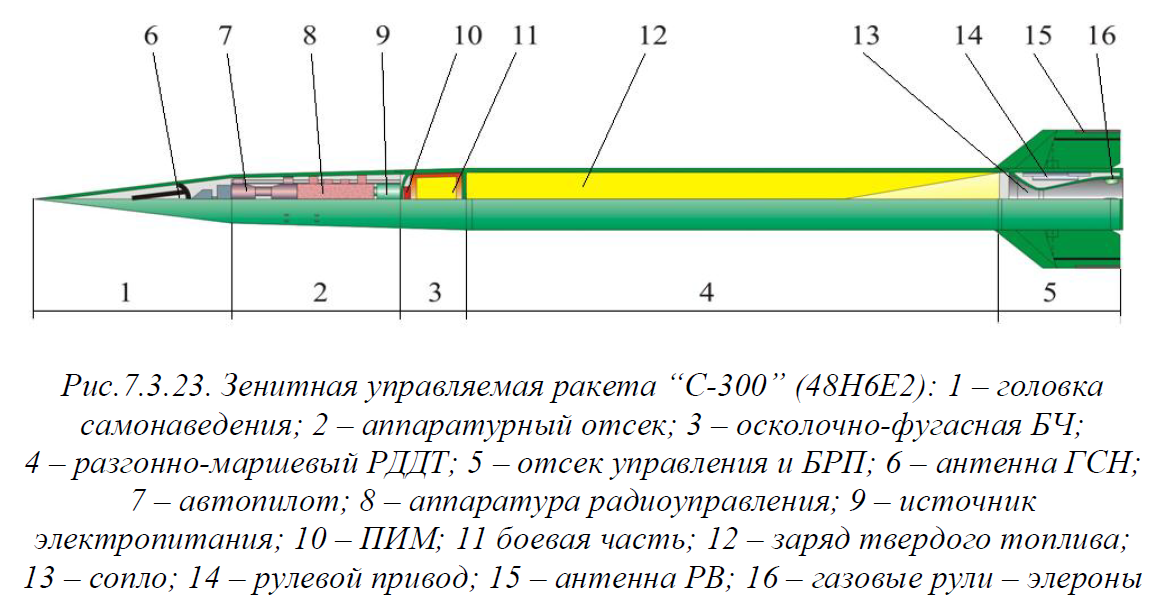

Бескрылая нормальная схема (частный случай "нормальной" схемы) - "схема с несущим корпусом"

АД ОУ - рули-элероны выполняют еще и роль стабилизирующих поверхностей, обеспечивающих необходимые запасы статической устойчивости.

стр. 455 про бескрылую схему можно многое узнать

In [ ]:
def aero_coef(state, action, n_y_a):
    """
    Ф-ция расчёта аэродинамических коэффициентов ракеты в состоянии state
    argument: state {np.ndarray} -- состояние ракеты; 
                                    [v,   x, y, Q,       alpha,   t]
                                    [м/с, м, м, радианы, градусы, с]
              action {int} -- управляющее воздействие на протяжении шага;
    return:
    """
    a = 0.2 # коэффициент согласования (0.15 по Астаховой)
    L_korp = # длина корпуса
    L_nos = # длина головной части
    L_korm = # длина кормовой части
    L_oper = # размах оперения
    lambd_nos =  # относительное удлинение носовой части
    lambd_korp =  # относительное удлинение корпуса
    d = 
    d_korm =
    S_oper = 
    W_nos = # объем головной части (1/3 * L_nos * S_mid для конической ГЧ; 0.393 * d**3 * lambd_nos)
    lambd_oper, c_oper, tg_khi_05_oper, nu_k_oper =
    # mz_cy = - 0.02...0.06 для обычной схемы (x_t - x_fa) / L_korp
    
    # вспомогательные вычисления
    S_mid = np.pi * d**2 / 4
    n_korm = d_korm / d
    Mach = state[0] / table_atm(state[2], 4)
    
    # коэф-т подъемной силы корпуса
    Cy_alpha_nos  = Cy_alpha_nos_cil(2)
    Cy_alpha_korm = - 2 / 57.3 * (1 - n_korm ** 2) * a
    Cy_alpha_korp = Cy_alpha_nos + Cy_alpha_korm
    
    # коэф-т подъемной силы оперения
    k_t_oper = table_3_21(Mach, lambd_nos)
    Cy_alpha_k_oper = Cy_alpha_iz_kr(Mach * np.sqrt(k_t_oper), lambd_oper, c_oper, tg_khi_05_oper)
    D_oper = d / L_oper
    K_aa_oper = 1 + 3 * D_oper - (D_oper * (1 - D_oper)) / nu_k_oper
    Cy_alpha_oper = Cy_alpha_k_oper * K_aa_oper
    
    # коэф-т подъемной силы
    Cy_alpha = Cy_alpha_korp * (S_mid / S_mid)  + Cy_alpha_oper * (S_oper / S_mid) * k_t_oper    
    
    # центр давления корпуса
    delta_x_f = F_iz_korp(Mach, lambd_nos, lambd_korp, L_nos)
    x_fa_nos_cil = L_nos - W_nos / S_mid + delta_x_f
    x_fa_korm = L_korp - 0.5 * L_korm   
    x_fa_korp = 1 / Cy_alpha_korp * (Cy_alpha_nos * x_fa_nos_cil)
    
    
    
    
    
    
    K_delt_0_op = k_aa_op
    K_delt_0_kr = k_aa_kr
    k_delt_0_op = k_aa_op ** 2 / K_aa_op
    k_delt_0_kr = k_aa_kr ** 2 / K_aa_kr

    if mach <= 1.4:
        k_sh = 0.85
    else:
        k_sh = 0.99
    n_ef = k_sh * kk.cos(0)
    cy1_delt_op = cy1_alf_op * K_delt_0_op * n_ef
    cyy1_delt_op.append(cy1_delt_op)
    
    ni_atm = Tabl.tab_atm(self.y, 5)
            re_f = self.v * L_f / ni_atm
            # print(re_f * h / L_f)

            re_t = Tabl.tab_4_5(mach, re_f, 7, L_f)  # test (max for current speed and form)

            x_tt = re_t * ni_atm / self.v
            if x_tt >= (0.26 / L_f):
                x_tt = f_t / Ff
            # print(x_t)
            # x_t = 0.08  # координата точки перехода (до точного определения)

            # cx_tr = Tabl.tab_4_2(re_f, x_t) / 2 * Ff / Sf
            # cxx_tr.append(cx_tr)
            cx_tr = Tabl.tab_4_2(re_f, x_tt) / 2 * Ff / Sf
            cxx_tr.append(cx_tr)

            cx_nos = Tabl.tab_4_11(mach, l_nos_)
            cxx_con.append(cx_nos)
            """cx_zat = Tabl.tab_4_13(mach, l_zat)
            cxx_zat.append(cx_zat)
            cx_nos = cx_con * (1 - r_ ** 2 * kk.cos(teta) ** 2 * (3.1 - 1.4 * r_ * kk.cos(teta) - 0.7 * r_ ** 2 *
                                                                  kk.cos(teta) ** 2)) + cx_zat * r_ ** 2"""
            cxx_nos.append(cx_nos)

            cx_korm = Tabl.tab_4_24(mach, nu_kor, l_korm)
            cxx_korm.append(cx_korm)
            cx_0f = cx_tr + cx_nos + cx_korm
            cxx_0f.append(cx_0f)

            # профилное сопротивление несущих поверхностей
            re_k = self.v * b_kr / ni_atm
            re_k_t = Tabl.tab_4_5(mach, re_k, 5, b_kr)
            x_t_kr = re_k_t / re_k
            c_f_kr = Tabl.tab_4_2(re_k, x_t_kr)
            ni_c_kr = Tabl.tab_4_28(x_t_kr, c_kr)

            re_op = self.v * b_op / ni_atm
            re_op_t = Tabl.tab_4_5(mach, re_op, 5, b_op)
            x_t_op = re_op_t / re_op
            c_f_op = Tabl.tab_4_2(re_op, x_t_op)
            ni_c_op = Tabl.tab_4_28(x_t_op, c_op)

            cx_kr_pr = c_f_kr * ni_c_kr
            cxx_kr_pr.append(cx_kr_pr)
            cx_op_pr = c_f_op * ni_c_op
            cxx_op_pr.append(cx_op_pr)
            # волновое сопротивление несущих поверхностей
            if mach < 1.1:
                cx_op_vol = Tabl.tab_4_30(mach, nu_k_op, l_op, tan_05_op, c_op)
                cx_kr_vol = Tabl.tab_4_30(mach, nu_k_kr, l_kr, tan_05_kr, c_kr)
                cxx_kr_vol.append(cx_kr_vol)
                cxx_op_vol.append(cx_op_vol)
            elif mach >= 1.1:

                cx_kr_vol = (Tabl.tab_4_30(mach, nu_k_kr, l_kr, tan_05_kr, c_kr)) * \
                            (1 + Tabl.tab_4_32(mach, tan_05_kr) * (koef_kr - 1))
                cxx_kr_vol.append(cx_kr_vol)
                cx_op_vol = (Tabl.tab_4_30(mach, nu_k_op, l_op, tan_05_op, c_op)) * \
                            (1 + Tabl.tab_4_32(mach, tan_05_op) * (koef_op - 1))
                cxx_op_vol.append(cx_op_vol)
            # cx_nes =
            cx_0_op = cx_op_pr + cx_op_vol
            cx_0_kr = cx_kr_pr + cx_kr_vol
            cxx_0_kr.append(cx_0_kr)
            cxx_0_op.append(cx_0_op)

            cx_0 = 1.05 * (cx_0f * S__f + cx_0_op * k_t_op * S_op + cx_0_kr * k_t_kr * S_kr)
            cxx_0.append(cx_0)
            f_x = cx_0 * Tabl.tab_atm(self.y, 4) * self.v ** 2 * d ** 2 * kk.pi / 8
            f_xx.append(f_x)
            f_y = cy1_alf * Tabl.tab_atm(self.y, 4) * self.v ** 2 * d ** 2 * kk.pi / 8
            f_yy.append(f_y)
            # индуктивное сопротивление
            delt_cx1 = 2 * Tabl.tab_4_40(mach, l_nos, 1) * kk.sin(self.alf) ** 2
            cx_f_ind = cy1_alf_f * kk.sin(self.alf) + delt_cx1 * kk.cos(self.alf)
            # cx_op_ind = cy

            # фокусы отдельных частей ЛА по углу атаки
            x_fa_nos_cill = L_nos - W_nos / S_f + Tabl.tab_5_7(mach, l_nos, l_cil, L_nos)
            x_ffa_nos_cill.append(x_fa_nos_cill)
            x_fa_korm = L_f - 0.5 * L_korm
            """ + cy_korm * x_fa_korm"""
            x_fa_f = 1 / cy1_alf_f * (cy_nos * x_fa_nos_cill)
            # print(cy_korm)
            x_ffa_f.append(x_fa_f)

            if mach < 1:
                x__iz_op = 0.21
                x__iz_kr = 0.15
            else:
                x__iz_op = 0.4
                x__iz_kr = 0.21

            x_f_iz_op = x_b_a_op + b_a_op * x__iz_op
            x_f_delt_op = x_f_iz_op - tan_05_op * Tabl.tab_5_11(D_op, L_k_op)
            x_f_iz_kr = x_b_a_kr + b_a_kr * x__iz_kr
            x_f_delt_kr = x_f_iz_kr - tan_05_kr * Tabl.tab_5_11(D_kr, L_k_kr)

            if mach > 1:
                b__b_op = b_op / (kk.pi / 2 * d * kk.sqrt(mach ** 2 - 1))
                b__b_kr = b_kr / (kk.pi / 2 * d * kk.sqrt(mach ** 2 - 1))
                L__hv_op = L_hv_op / (kk.pi * d * kk.sqrt(mach ** 2 - 1))
                L__hv_kr = L_hv_kr / (kk.pi * d * kk.sqrt(mach ** 2 - 1))
                F_1_op = 1 - 1 / (c_const_op * b__b_op ** 2) * (kk.e ** (-c_const_op * L__hv_op ** 2) - kk.e ** (-c_const_op * (b__b_op + L__hv_op) ** 2)) + kk.sqrt(kk.pi) / (b__b_op * kk.sqrt(c_const_op)) * Tabl.tab_int_ver(L__hv_op * kk.sqrt(2 * c_const_op))

                F_1_kr = 1 - 1 / (c_const_kr * b__b_kr ** 2) * (kk.e ** (-c_const_kr * L__hv_kr ** 2) - kk.e ** (-c_const_kr * (b__b_kr + L__hv_kr) ** 2)) + kk.sqrt(kk.pi) / (b__b_kr * kk.sqrt(c_const_kr)) * Tabl.tab_int_ver(L__hv_kr * kk.sqrt(2 * c_const_kr))

                F_op = 1 - kk.sqrt(kk.pi) / (2 * b__b_op * kk.sqrt(c_const_op)) * (Tabl.tab_int_ver((b__b_op + L__hv_op) * kk.sqrt(2 * c_const_op)) - Tabl.tab_int_ver(L__hv_op * kk.sqrt(2 * c_const_op)))
                F_kr = 1 - kk.sqrt(kk.pi) / (2 * b__b_kr * kk.sqrt(c_const_kr)) * (Tabl.tab_int_ver((b__b_kr + L__hv_kr) * kk.sqrt(2 * c_const_kr)) - Tabl.tab_int_ver(L__hv_kr * kk.sqrt(2 * c_const_kr)))

                x_f_b_op = x_f_iz_op + 0.02 * l_op * tan_05_op
                x_f_b_kr = x_f_iz_kr + 0.02 * l_kr * tan_05_kr

                x_f_ind_op = x_b_op + b_op * x_f_b_op * F_op * F_1_op
                x_f_ind_kr = x_b_kr + b_kr * x_f_b_kr * F_kr * F_1_kr
                x_fa_op = 1 / K_aa_op * (x_f_iz_op + (k_aa_op - 1) * x_f_delt_op + (K_aa_op - k_aa_op) * x_f_ind_op)
                x_fa_kr = 1 / K_aa_kr * (x_f_iz_kr + (k_aa_kr - 1) * x_f_delt_kr + (K_aa_kr - k_aa_kr) * x_f_ind_kr)
            else:
                x_f_b_op = x_f_iz_op + 0.02 * l_op * tan_05_op
                x_f_b_kr = x_f_iz_kr + 0.02 * l_kr * tan_05_kr
                x_f_ind_op = x_b_op + b_op * x_f_b_op
                x_f_ind_kr = x_b_kr + b_kr * x_f_b_kr
                x_fa_op = 1 / K_aa_op * (x_f_iz_op + (k_aa_op - 1) * x_f_delt_op + (K_aa_op - k_aa_op) * x_f_ind_op)
                x_fa_kr = 1 / K_aa_kr * (x_f_iz_kr + (k_aa_kr - 1) * x_f_delt_kr + (K_aa_kr - k_aa_kr) * x_f_ind_kr)

            print(x_fa_op)
            x_ffa_op.append(x_fa_op)
            print(x_fa_kr)
            x_ffa_kr.append(x_fa_kr)

            # координаты фокуса рулей (передних консолей) по углам отклонения

            x_fd_op = 1 / K_delt_0_op * (k_delt_0_op * x_f_iz_op + (K_delt_0_op - k_delt_0_op) * x_f_ind_op)

            # Демпфирующие моменты АД поверхностей
            # x_c_ob - координата центра тяжести объема тела вращения
            x_c_ob = L_f * ((2 * (l_nos + l_cil)**2 - l_nos**2) / (4*(l_nos+l_cil) * (l_nos+l_cil - 2/3*l_nos)))
            m_z_wz_f = -2 * (1 - self.x_ct / L_f + (self.x_ct / L_f) ** 2 - x_c_ob / L_f)

            x__ct_op = (self.x_ct - x_b_a_op) / b_a_op  # координата центра тяжести, измеренная от начала САХ рулей
            m_z_wz_op = -57.3 * (cy1_alf_op * (x__ct_op - 1 / 2) ** 2 * K_aa_op)

            m_z_wz_delt_kr = -57.3 * (cy1_alf_kr * K_aa_kr) * eps_sr_alf * (self.x_ct - x_c_pl_ba) / b_a_kr * (self.x_ct - x_fa_kr) / b_a_kr
            x__ct_kr = (self.x_ct - x_b_a_kr) / b_a_kr
            m_z_wz_iz_kr = -57.3 * (cy1_alf_op * (x__ct_kr - 1 / 2) ** 2 * K_aa_kr)
            m_z_wz_kr = m_z_wz_iz_kr * K_aa_kr + m_z_wz_delt_kr
            

            # mz_alf = -cy1_alf * (x_fa_f - x_t) / L_f
            
             """khi = cy_delt * self.delt / cy1_alf
            self.alf_potr = (n_y_a * self.m * g) / (cy1_alf * q * Sf * (1 + khi) + p / 57.3)"""
    
    
    
    return {
        '': ,
    }

In [ ]:
"""
    Расчёт крыла
    k_t1 = table_3_21(Mach, lambd_nos)
    Cy_alpha_kkr = Cy_alpha_iz_kr(Mach * np.sqrt(k_t1), lambd_kr, c_kr, tg_khi_05_kr)
    D_kr = d / l_kr
    K_aa_kr = 1 + 3 * D_kr - (D_kr * (1 - D_kr)) / nu_k_kr
    k_aa_kr = (1 + 0.41 * D_kr) ** 2 * ((1 + 3 * D_kr - 1 / nu_k_kr * D_kr * (1 - D_kr)) / (1 + D_kr) ** 2)
    eps_sr_alf = 0  # для "утки" 
    Cy_alpha_kr = (Cy_alpha_kkr * K_aa_kr) * (1 - eps_sr_alf)
    """